In [136]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, balanced_accuracy_score, f1_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm

In [2]:
label_dataset_2015 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2015/2015_clean.csv")
label_dataset_2016 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2016/2016_clean.csv")
label_dataset_2017 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2017/2017_clean.csv")
label_dataset_2018 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2018/2018_clean.csv")

/var/folders/v0/37fzp2hx3ns37mhx_9_xr5qh0000gn/T/ipykernel_48536/1115557230.py:3: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  label_dataset_2017 = pd.read_csv("/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/id/2017/2017_clean.csv")


In [199]:
def proprocess_data(data_2015, data_2016, data_2017, data_2018, drug_name, param_dict, smote_param_dict):
    data_2015 = data_2015.loc[data_2015['species'] == "Escherichia coli"]
    data_2016 = data_2016.loc[data_2016['species'] == "Escherichia coli"]
    data_2017 = data_2017.loc[data_2017['species'] == "Escherichia coli"]
    data_2018 = data_2018.loc[data_2018['species'] == "Escherichia coli"]
    
    only_drug_15 = data_2015[['code', drug_name]].dropna()
    only_drug_16 = data_2016[['code', drug_name]].dropna()
    only_drug_17 = data_2017[['code', drug_name]].dropna()
    only_drug_18 = data_2018[['code', drug_name]].dropna()
    
    print("Assembling 2015 DRIAMS data...")
    starting_dataset_15 = np.zeros((only_drug_15.shape[0], 6000))
    base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2015/"
    for i in range(only_drug_15.shape[0]):
        starting_dataset_15[i] = np.loadtxt(base_path + only_drug_15.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)
    
    print("Assembling 2016 DRIAMS data...")
    starting_dataset_16 = np.zeros((only_drug_16.shape[0], 6000))
    base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2016/"
    for i in range(only_drug_16.shape[0]):
        starting_dataset_16[i] = np.loadtxt(base_path + only_drug_16.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)

    print("Assembling 2017 DRIAMS data...")        
    starting_dataset_17 = np.zeros((only_drug_17.shape[0], 6000))
    base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2017/"
    for i in range(only_drug_17.shape[0]):
        starting_dataset_17[i] = np.loadtxt(base_path + only_drug_17.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)
        
    print("Assembling 2018 DRIAMS data...")
    starting_dataset_18 = np.zeros((only_drug_18.shape[0], 6000))
    base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2018/"
    for i in range(only_drug_18.shape[0]):
        starting_dataset_18[i] = np.loadtxt(base_path + only_drug_18.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)
        
    e_coli_numpy_15 = np.hstack((starting_dataset_15, np.array(only_drug_15[drug_name]).reshape(only_drug_15.shape[0], 1)))
    e_coli_numpy_16 = np.hstack((starting_dataset_16, np.array(only_drug_16[drug_name]).reshape(only_drug_16.shape[0], 1)))
    e_coli_numpy_17 = np.hstack((starting_dataset_17, np.array(only_drug_17[drug_name]).reshape(only_drug_17.shape[0], 1)))
    e_coli_numpy_18 = np.hstack((starting_dataset_18, np.array(only_drug_18[drug_name]).reshape(only_drug_18.shape[0], 1)))
    
    e_coli_numpy = np.vstack((e_coli_numpy_15, e_coli_numpy_16, e_coli_numpy_17, e_coli_numpy_18))
    
    column_list = []
    for i in range(1, 6001):
        column_list.append("Bin " + str(i))
    column_list.append("Class")
    
    e_coli_df = pd.DataFrame(e_coli_numpy, columns = column_list)
    
    e_coli_df = e_coli_df[(e_coli_df['Class'] == "S") | (e_coli_df['Class'] == "R")]
    
    e_coli_df_X = e_coli_df.iloc[:,:-1]
    e_coli_df_y = e_coli_df.iloc[:,-1]
    
    e_coli_df_X = e_coli_df_X.astype(np.float64)
    e_coli_df_y[e_coli_df_y == "S"] = 0
    e_coli_df_y[e_coli_df_y == "R"] = 1
    e_coli_df_y = e_coli_df_y.astype(np.int64)
    
    e_coli_df_X_train, e_coli_df_X_val_test, e_coli_df_y_train, e_coli_df_y_val_test = train_test_split(e_coli_df_X, e_coli_df_y, stratify=e_coli_df_y, test_size=0.2, random_state=42)
    e_coli_df_X_val, e_coli_df_X_test, e_coli_df_y_val, e_coli_df_y_test = train_test_split(e_coli_df_X_val_test, e_coli_df_y_val_test, test_size=0.50, stratify=e_coli_df_y_val_test, random_state=42)
    
    without_smote_roc_auc = []
    without_smote_accuracy = []
    without_smote_f1_score = []
    
    print("Performing Regular LightGBM Model Evaluation...")
    regular_lightgbm = lightgbm.LGBMClassifier(objective="binary", seed=42, **param_dict)
    print(regular_lightgbm.get_params())
    
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    fold_count = 1
    for train_index, test_index in skf.split(e_coli_df_X_train, e_coli_df_y_train):
        print(f"Evaluating Fold {fold_count}/10...")
        X_train, X_test = e_coli_df_X_train.iloc[train_index], e_coli_df_X_train.iloc[test_index]
        y_train, y_test = e_coli_df_y_train.iloc[train_index], e_coli_df_y_train.iloc[test_index]
        _ = regular_lightgbm.fit(X_train, y_train, eval_set = (e_coli_df_X_val, e_coli_df_y_val), callbacks = [lightgbm.early_stopping(50)])
    
        e_coli_df_y_pred = regular_lightgbm.predict(X_test)
        without_smote_roc_auc.append(roc_auc_score(y_test, e_coli_df_y_pred))
        without_smote_accuracy.append(accuracy_score(y_test, e_coli_df_y_pred))
        without_smote_f1_score.append(f1_score(y_test, e_coli_df_y_pred))
        fold_count += 1

    with_smote_roc_auc = []
    with_smote_accuracy = []
    with_smote_f1_score = []
    
    print("Performing Oversampled LightGBM Model Evaluation...")    
    smote_lightgbm = lightgbm.LGBMClassifier(objective="binary", seed=42, verbose = -1, **smote_param_dict)
    print(smote_lightgbm.get_params())
    
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    fold_count = 1
    for train_index, test_index in skf.split(e_coli_df_X_train, e_coli_df_y_train):
        print(f"Evaluating Fold {fold_count}/10...")
        
        X_train, y_train = e_coli_df_X_train.iloc[train_index], e_coli_df_y_train.iloc[train_index]
        X_test, y_test = e_coli_df_X_train.iloc[test_index], e_coli_df_y_train.iloc[test_index]
        
        e_coli_df_X_train_resampled, e_coli_df_y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)
        
        _ = smote_lightgbm.fit(e_coli_df_X_train_resampled, e_coli_df_y_train_resampled, eval_set = (e_coli_df_X_val, e_coli_df_y_val), callbacks = [lightgbm.early_stopping(50)])

        e_coli_df_y_pred_resampled = smote_lightgbm.predict(X_test)
        with_smote_roc_auc.append(roc_auc_score(y_test, e_coli_df_y_pred_resampled))
        with_smote_accuracy.append(accuracy_score(y_test, e_coli_df_y_pred_resampled))
        with_smote_f1_score.append(f1_score(y_test, e_coli_df_y_pred_resampled))
        fold_count += 1
    
#     fpr_regular, tpr_regular, thresholds = roc_curve(ceftriaxone_y_test, regular_lightgbm.predict_proba(ceftriaxone_X_test)[:, 1], pos_label=1)
#     auc = round(roc_auc_score(ceftriaxone_y_test, ceftriaxone_y_pred), 4)
#     plt.plot(fpr_regular, tpr_regular, label="Without SMOTE, AUC=" + str(auc))

#     fpr_smote, tpr_smote, thresholds = roc_curve(ceftriaxone_y_test, smote_lightgbm.predict_proba(ceftriaxone_X_test)[:, 1], pos_label=1)
#     auc = round(roc_auc_score(ceftriaxone_y_test, ceftriaxone_y_pred_resampled), 4)
#     plt.plot(fpr_smote, tpr_smote, label="With SMOTE, AUC=" + str(auc))
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title("ROC Curves for E. Coli using LightGBM - Ceftriaxone Antibiotic")
#     plt.legend(loc = "lower right")
    print("Done!")
    return [without_smote_roc_auc, with_smote_roc_auc]

In [197]:
final_auroc_results = np.zeros((2, 3, 10))

In [207]:
e_coli_ceftriaxone_results = proprocess_data(label_dataset_2015, label_dataset_2016, 
                                        label_dataset_2017, label_dataset_2018, "Ceftriaxone", {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'n_estimators': 300}, {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'n_estimators': 300})
final_auroc_results[0, 0] = e_coli_ceftriaxone_results[0]
final_auroc_results[1, 0] = e_coli_ceftriaxone_results[1]

Assembling 2015 DRIAMS data...
Assembling 2016 DRIAMS data...
Assembling 2017 DRIAMS data...
Assembling 2018 DRIAMS data...
Performing Regular LightGBM Model Evaluation...
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'num_leaves': 31, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'seed': 42}
Evaluating Fold 1/10...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.274637
Evaluating Fold 2/10...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.280333
Evaluating Fold 3/10...
Training until validation scores 

In [208]:
final_auroc_results

array([[[0.72827215, 0.75216908, 0.70044494, 0.7167779 , 0.74803485,
         0.69631072, 0.7546904 , 0.69953652, 0.74354839, 0.68702176],
        [0.70823452, 0.68096179, 0.73876479, 0.70761867, 0.7037628 ,
         0.71727273, 0.69181818, 0.70818182, 0.70272727, 0.71090909],
        [0.57098765, 0.49845679, 0.55401235, 0.53703704, 0.5       ,
         0.51697531, 0.55555556, 0.5       , 0.49691358, 0.51923077]],

       [[0.78756025, 0.75812013, 0.76043752, 0.73240638, 0.76618465,
         0.73170189, 0.77697442, 0.71698183, 0.74613653, 0.66185296],
        [0.73099473, 0.72648221, 0.75638213, 0.7223441 , 0.70303151,
         0.73272727, 0.72727273, 0.71272727, 0.73272727, 0.72909091],
        [0.66975309, 0.6404321 , 0.6712963 , 0.6095679 , 0.65895062,
         0.70987654, 0.71296296, 0.58641975, 0.70073599, 0.66227445]]])

In [202]:
e_coli_ciprofloxacin_results = proprocess_data(label_dataset_2015, label_dataset_2016, 
                                        label_dataset_2017, label_dataset_2018, "Ciprofloxacin", {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'n_estimators': 300}, {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'n_estimators': 300})
final_auroc_results[0, 1] = e_coli_ciprofloxacin_results[0]
final_auroc_results[1, 1] = e_coli_ciprofloxacin_results[1]

Assembling 2015 DRIAMS data...
Assembling 2016 DRIAMS data...
Assembling 2017 DRIAMS data...
Assembling 2018 DRIAMS data...
Performing Regular LightGBM Model Evaluation...
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'num_leaves': 31, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'seed': 42}
Evaluating Fold 1/10...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.401158
Evaluating Fold 2/10...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.391664
Evaluating Fold 3/10...
Training until validation scores 

In [203]:
final_auroc_results

array([[[0.72827215, 0.75216908, 0.70044494, 0.7167779 , 0.74803485,
         0.69631072, 0.7546904 , 0.69953652, 0.74354839, 0.68702176],
        [0.70823452, 0.68096179, 0.73876479, 0.70761867, 0.7037628 ,
         0.71727273, 0.69181818, 0.70818182, 0.70272727, 0.71090909],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[0.78524286, 0.74501298, 0.71950315, 0.73997034, 0.776066  ,
         0.71950315, 0.79925844, 0.74733037, 0.77876969, 0.69189797],
        [0.73099473, 0.72648221, 0.75638213, 0.7223441 , 0.70303151,
         0.73272727, 0.72727273, 0.71272727, 0.73272727, 0.72909091],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]]])

In [204]:
e_coli_cefepime_results = proprocess_data(label_dataset_2015, label_dataset_2016, 
                                        label_dataset_2017, label_dataset_2018, "Cefepime", {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'n_estimators': 400}, {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'n_estimators': 400})
final_auroc_results[0, 2] = e_coli_cefepime_results[0]
final_auroc_results[1, 2] = e_coli_cefepime_results[1]

Assembling 2015 DRIAMS data...
Assembling 2016 DRIAMS data...
Assembling 2017 DRIAMS data...
Assembling 2018 DRIAMS data...
Performing Regular LightGBM Model Evaluation...
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 400, 'n_jobs': -1, 'num_leaves': 31, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'seed': 42}
Evaluating Fold 1/10...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.224318
Evaluating Fold 2/10...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.235942
Evaluating Fold 3/10...
Training until validation scores do

In [205]:
final_auroc_results

array([[[0.72827215, 0.75216908, 0.70044494, 0.7167779 , 0.74803485,
         0.69631072, 0.7546904 , 0.69953652, 0.74354839, 0.68702176],
        [0.70823452, 0.68096179, 0.73876479, 0.70761867, 0.7037628 ,
         0.71727273, 0.69181818, 0.70818182, 0.70272727, 0.71090909],
        [0.57098765, 0.49845679, 0.55401235, 0.53703704, 0.5       ,
         0.51697531, 0.55555556, 0.5       , 0.49691358, 0.51923077]],

       [[0.78524286, 0.74501298, 0.71950315, 0.73997034, 0.776066  ,
         0.71950315, 0.79925844, 0.74733037, 0.77876969, 0.69189797],
        [0.73099473, 0.72648221, 0.75638213, 0.7223441 , 0.70303151,
         0.73272727, 0.72727273, 0.71272727, 0.73272727, 0.72909091],
        [0.66975309, 0.6404321 , 0.6712963 , 0.6095679 , 0.65895062,
         0.70987654, 0.71296296, 0.58641975, 0.70073599, 0.66227445]]])

In [194]:
e_coli_piperacillin_results = proprocess_data(label_dataset_2015, label_dataset_2016, 
                                        label_dataset_2017, label_dataset_2018, "Piperacillin-Tazobactam", {'boosting_type': 'dart', 'learning_rate': 0.1, 'n_estimators': 200}, {'boosting_type': 'dart', 'learning_rate': 0.1, 'n_estimators': 200})
final_auroc_results[0, 3] = e_coli_piperacillin_results[0]
final_auroc_results[1, 3] = e_coli_piperacillin_results[1]

Assembling 2015 DRIAMS data...
Assembling 2016 DRIAMS data...
Assembling 2017 DRIAMS data...
Assembling 2018 DRIAMS data...
Performing Regular LightGBM Model Evaluation...
{'boosting_type': 'dart', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 31, 'objective': 'binary', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'seed': 42}
Evaluating Fold 1/10...
[1]	valid_0's binary_logloss: 0.231186
[2]	valid_0's binary_logloss: 0.231825
[3]	valid_0's binary_logloss: 0.232067
[4]	valid_0's binary_logloss: 0.233077
[5]	valid_0's binary_logloss: 0.230096
[6]	valid_0's binary_logloss: 0.228891
[7]	valid_0's binary_logloss: 0.227454
[8]	valid_0's binary_logloss: 0.227392
[9]	valid_0's binary_logloss: 0.227652
[10]	

In [195]:
final_auroc_results

array([[[0.74137931, 0.73744902, 0.72504635, 0.73401928, 0.75952911,
         0.70367075, 0.73835743, 0.7167779 , 0.72288072, 0.66215304],
        [0.71551383, 0.68824111, 0.7497507 , 0.71401742, 0.68179099,
         0.71454545, 0.68818182, 0.69090909, 0.71090909, 0.70454545],
        [0.62808642, 0.55401235, 0.59259259, 0.51851852, 0.57253086,
         0.60802469, 0.57407407, 0.53395062, 0.55460589, 0.55769231],
        [0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
         0.5       , 0.5       , 0.5       , 0.5       , 0.5       ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[0.78524286, 0.74501298, 0.71950315, 0.73997034, 0.776066  ,
         0.71950315, 0.79925844, 0.74733037, 0.77876969, 0.69189797],
        [0.6965415 , 0.72832675, 0.75649847, 0.72728028, 0.70422816,
         0.73818182, 0.68545455, 0.68363636, 0.73181818, 0.73363636],
        [0.67746914, 0.64

In [115]:
e_coli_tobramycin_results = proprocess_data(label_dataset_2015, label_dataset_2016, 
                                        label_dataset_2017, label_dataset_2018, "Tobramycin")
final_auroc_results[0, 4] = e_coli_tobramycin_results[0]
final_auroc_results[1, 4] = e_coli_tobramycin_results[1]

Assembling 2015 DRIAMS data...
Assembling 2016 DRIAMS data...
Assembling 2017 DRIAMS data...
Assembling 2018 DRIAMS data...
Performing Regular LightGBM Model Evaluation...
Evaluating Fold 1/5...
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.354343
Evaluating Fold 2/5...
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.343964
Evaluating Fold 3/5...
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.355844
Evaluating Fold 4/5...
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.340934
Evaluating Fold 5/5...
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.350399
Performing Oversampled LightGBM M

In [116]:
final_auroc_results

array([[[0.72343344, 0.72297924, 0.71642566, 0.71528529, 0.69391199],
        [0.7050363 , 0.72139498, 0.69868815, 0.6973995 , 0.69137061],
        [0.53472222, 0.54552469, 0.54552469, 0.51886792, 0.52675868],
        [0.5       , 0.5       , 0.5       , 0.5       , 0.5       ],
        [0.50968029, 0.51267949, 0.52134842, 0.51325153, 0.53902472]],

       [[0.75640527, 0.72353541, 0.73225806, 0.74143203, 0.72214246],
        [0.72278502, 0.73553044, 0.72482576, 0.69663708, 0.71888389],
        [0.66975309, 0.66126543, 0.63811728, 0.64399895, 0.68019159],
        [0.50879959, 0.49929775, 0.50809734, 0.5       , 0.4978903 ],
        [0.54024761, 0.56118833, 0.56479032, 0.54490162, 0.54711401]]])

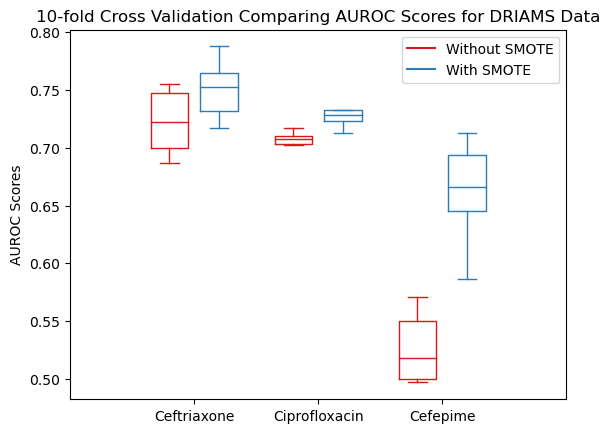

In [231]:
axes_ticks = ['Ceftriaxone', 'Ciprofloxacin', 'Cefepime']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(final_auroc_results[0].T, positions=np.array(range(len(final_auroc_results[0])))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(final_auroc_results[1].T, positions=np.array(range(len(final_auroc_results[1])))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Without SMOTE')
plt.plot([], c='#2C7BB6', label='With SMOTE')
plt.legend()

plt.xticks(range(0, len(axes_ticks) * 2, 2), axes_ticks)
plt.xlim(-2, len(axes_ticks)*2)

plt.title("10-fold Cross Validation Comparing AUROC Scores for DRIAMS Data")
plt.ylabel("AUROC Scores")

plt.savefig("boxplots.png")

In [131]:
final_auroc_results

array([[[0.72343344, 0.72297924, 0.71642566, 0.71528529, 0.69391199],
        [0.7050363 , 0.72139498, 0.69868815, 0.6973995 , 0.69137061],
        [0.53472222, 0.54552469, 0.54552469, 0.51886792, 0.52675868],
        [0.5       , 0.5       , 0.5       , 0.5       , 0.5       ],
        [0.50968029, 0.51267949, 0.52134842, 0.51325153, 0.53902472]],

       [[0.75640527, 0.72353541, 0.73225806, 0.74143203, 0.72214246],
        [0.72278502, 0.73553044, 0.72482576, 0.69663708, 0.71888389],
        [0.66975309, 0.66126543, 0.63811728, 0.64399895, 0.68019159],
        [0.50879959, 0.49929775, 0.50809734, 0.5       , 0.4978903 ],
        [0.54024761, 0.56118833, 0.56479032, 0.54490162, 0.54711401]]])

In [119]:
np.array(range(len(final_auroc_results[0])))*2.0-0.4

array([-0.4,  1.6,  3.6,  5.6,  7.6])

In [30]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
test = skf.split(ceftriaxone_X_train, ceftriaxone_y_train)

In [31]:
test

<generator object _BaseKFold.split at 0x49d225ac0>

In [83]:
final_auroc_results = np.zeros((2, 5, 5))
final_auroc_results[1, 0] = [1, 2, 3, 4, 5]
final_auroc_results

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[1., 2., 3., 4., 5.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]])

In [191]:
param_grid = {
            'boosting_type': ['gbdt', 'dart', 'goss'],
            'n_estimators': [25, 50, 100, 200],
            'learning_rate': 10.0 ** np.arange(-3, 4),
        }

drug_name = "Piperacillin-Tazobactam"

label_dataset_2015 = label_dataset_2015.loc[label_dataset_2015['species'] == "Escherichia coli"]
label_dataset_2016 = label_dataset_2016.loc[label_dataset_2016['species'] == "Escherichia coli"]
label_dataset_2017 = label_dataset_2017.loc[label_dataset_2017['species'] == "Escherichia coli"]
label_dataset_2018 = label_dataset_2018.loc[label_dataset_2018['species'] == "Escherichia coli"]

only_drug_15 = label_dataset_2015[['code', drug_name]].dropna()
only_drug_16 = label_dataset_2016[['code', drug_name]].dropna()
only_drug_17 = label_dataset_2017[['code', drug_name]].dropna()
only_drug_18 = label_dataset_2018[['code', drug_name]].dropna()

print("Assembling 2015 DRIAMS data...")
starting_dataset_15 = np.zeros((only_drug_15.shape[0], 6000))
base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2015/"
for i in range(only_drug_15.shape[0]):
    starting_dataset_15[i] = np.loadtxt(base_path + only_drug_15.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)

print("Assembling 2016 DRIAMS data...")
starting_dataset_16 = np.zeros((only_drug_16.shape[0], 6000))
base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2016/"
for i in range(only_drug_16.shape[0]):
    starting_dataset_16[i] = np.loadtxt(base_path + only_drug_16.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)

print("Assembling 2017 DRIAMS data...")        
starting_dataset_17 = np.zeros((only_drug_17.shape[0], 6000))
base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2017/"
for i in range(only_drug_17.shape[0]):
    starting_dataset_17[i] = np.loadtxt(base_path + only_drug_17.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)

print("Assembling 2018 DRIAMS data...")
starting_dataset_18 = np.zeros((only_drug_18.shape[0], 6000))
base_path = "/Users/seanathon48/Desktop/CS_534/Final_Project/archive/DRIAMS-A/binned_6000/2018/"
for i in range(only_drug_18.shape[0]):
    starting_dataset_18[i] = np.loadtxt(base_path + only_drug_18.iloc[i]["code"] + ".txt", skiprows = 1, usecols = 1)

e_coli_numpy_15 = np.hstack((starting_dataset_15, np.array(only_drug_15[drug_name]).reshape(only_drug_15.shape[0], 1)))
e_coli_numpy_16 = np.hstack((starting_dataset_16, np.array(only_drug_16[drug_name]).reshape(only_drug_16.shape[0], 1)))
e_coli_numpy_17 = np.hstack((starting_dataset_17, np.array(only_drug_17[drug_name]).reshape(only_drug_17.shape[0], 1)))
e_coli_numpy_18 = np.hstack((starting_dataset_18, np.array(only_drug_18[drug_name]).reshape(only_drug_18.shape[0], 1)))

e_coli_numpy = np.vstack((e_coli_numpy_15, e_coli_numpy_16, e_coli_numpy_17, e_coli_numpy_18))

column_list = []
for i in range(1, 6001):
    column_list.append("Bin " + str(i))
column_list.append("Class")

e_coli_df = pd.DataFrame(e_coli_numpy, columns = column_list)

e_coli_df = e_coli_df[(e_coli_df['Class'] == "S") | (e_coli_df['Class'] == "R")]

e_coli_df_X = e_coli_df.iloc[:,:-1]
e_coli_df_y = e_coli_df.iloc[:,-1]

e_coli_df_X = e_coli_df_X.astype(np.float64)
e_coli_df_y[e_coli_df_y == "S"] = 0
e_coli_df_y[e_coli_df_y == "R"] = 1
e_coli_df_y = e_coli_df_y.astype(np.int64)

e_coli_df_X_train, e_coli_df_X_val_test, e_coli_df_y_train, e_coli_df_y_val_test = train_test_split(e_coli_df_X, e_coli_df_y, stratify=e_coli_df_y, test_size=0.2, random_state=42)
e_coli_df_X_val, e_coli_df_X_test, e_coli_df_y_val, e_coli_df_y_test = train_test_split(e_coli_df_X_val_test, e_coli_df_y_val_test, test_size=0.50, stratify=e_coli_df_y_val_test, random_state=42)

Assembling 2015 DRIAMS data...
Assembling 2016 DRIAMS data...
Assembling 2017 DRIAMS data...
Assembling 2018 DRIAMS data...


In [192]:
param_grid = {
            'boosting_type': ['gbdt', 'dart', 'goss'],
            'n_estimators': [25, 50, 100, 200],
            'learning_rate': 10.0 ** np.arange(-3, 4),
        }

regular_lightgbm = lightgbm.LGBMClassifier(objective="binary", seed=42)
clf = GridSearchCV(regular_lightgbm, param_grid, verbose=3, scoring='roc_auc', cv=3)
clf.fit(e_coli_df_X_train, e_coli_df_y_train)

Fitting 3 folds for each of 84 candidates, totalling 252 fits
[CV 1/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=25;, score=0.528 total time=   2.8s
[CV 2/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=25;, score=0.633 total time=   2.7s
[CV 3/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=25;, score=0.573 total time=   2.6s
[CV 1/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=50;, score=0.548 total time=   4.5s
[CV 2/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=50;, score=0.667 total time=   4.4s
[CV 3/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=50;, score=0.569 total time=   4.7s
[CV 1/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=100;, score=0.591 total time=   8.0s
[CV 2/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=100;, score=0.684 total time=   7.8s
[CV 3/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=100;, score=0.595 total time=   8.4s
[CV 1/3]

GridSearchCV(cv=3, estimator=LGBMClassifier(objective='binary', seed=42),
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss'],
                         'learning_rate': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'n_estimators': [25, 50, 100, 200]},
             scoring='roc_auc', verbose=3)

In [193]:
clf.best_params_

{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 200}

In [182]:
param_grid = {
            'boosting_type': ['gbdt', 'dart', 'goss'],
            'n_estimators': [25, 50, 100, 200],
            'learning_rate': 10.0 ** np.arange(-3, 4),
        }

e_coli_df_X_train_resampled, e_coli_df_y_train_resampled = SMOTE(random_state=42).fit_resample(e_coli_df_X_train, e_coli_df_y_train)

regular_lightgbm = lightgbm.LGBMClassifier(objective="binary", seed=42)
clf = GridSearchCV(regular_lightgbm, param_grid, verbose=3, scoring='roc_auc', cv=3)
clf.fit(e_coli_df_X_train_resampled, e_coli_df_y_train_resampled)

Fitting 3 folds for each of 84 candidates, totalling 252 fits
[CV 1/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=25;, score=0.901 total time=   4.0s
[CV 2/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=25;, score=0.962 total time=   4.4s
[CV 3/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=25;, score=0.923 total time=   4.3s
[CV 1/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=50;, score=0.915 total time=   7.7s
[CV 2/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=50;, score=0.965 total time=   6.0s
[CV 3/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=50;, score=0.938 total time=   6.1s
[CV 1/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=100;, score=0.919 total time=  10.4s
[CV 2/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=100;, score=0.974 total time=  10.4s
[CV 3/3] END boosting_type=gbdt, learning_rate=0.001, n_estimators=100;, score=0.958 total time=  10.4s
[CV 1/3]

GridSearchCV(cv=3, estimator=LGBMClassifier(objective='binary', seed=42),
             param_grid={'boosting_type': ['gbdt', 'dart', 'goss'],
                         'learning_rate': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'n_estimators': [25, 50, 100, 200]},
             scoring='roc_auc', verbose=3)

In [183]:
clf.best_params_

{'boosting_type': 'goss', 'learning_rate': 0.1, 'n_estimators': 200}